In [1]:
%run gradients
%run representation_analysis
%run read_experiments


In [102]:
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

batch = 16
aux = 'catwall0'
exp_name = f'nav_pdistal_auxcat/nav_pdistal_batch{batch}aux{aux}'
# exp_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch}auxnone'
model, obs_rms, env_kwargs = load_model_and_env(exp_name, 0)

In [103]:
collect_processes = 1
auxiliary_truth_sizes = [1]
agent, envs, storage = initialize_ppo_training(model, obs_rms, env_kwargs=env_kwargs, num_steps=2048,
                                        num_processes=collect_processes, ppo_epoch=1, take_optimizer_step=False, normalize=True,
                                            agent_base='DecomposeGradPPOAux', new_aux=True,
                                            auxiliary_truth_sizes=auxiliary_truth_sizes)
data = populate_rollouts(model, envs, storage)


In [106]:
sampler = BatchSampler(SubsetRandomSampler(range(2048)), 2048, drop_last=True)

for indices in sampler:
    obs = storage.obs
    recurrent_hidden_states = storage.recurrent_hidden_states
    masks = storage.masks

    obs_batch = obs[:-1].view(-1, *obs.size()[2:])[indices]
    recurrent_hidden_states_batch = recurrent_hidden_states[:-1].view(
                    -1, recurrent_hidden_states.size(-1))[indices]
    masks_batch = masks[:-1].view(-1, 1)[indices]



    res = model.act(obs_batch, recurrent_hidden_states_batch, masks_batch)
    svd = torch.svd(res['actor_features'])

    vals = svd.S
    cum_svd_portion = vals.cumsum(0) / vals.sum() 
    srank = (cum_svd_portion > 0.95).numpy().argmax()

    print(srank)

12


In [105]:
cum_svd_portion

tensor([0.3239, 0.4790, 0.6032, 0.7011, 0.7607, 0.8021, 0.8397, 0.8737, 0.9009,
        0.9266, 0.9472, 0.9641, 0.9759, 0.9858, 0.9947, 1.0000],
       grad_fn=<DivBackward0>)

In [39]:
model.act

<bound method Policy.act of Policy(
  (base): FlexBaseAux(
    (gru): GRU(24, 16)
    (critic0): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
    )
    (actor0): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
    )
    (critic1): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
    )
    (actor1): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
    )
    (critic_head): Linear(in_features=16, out_features=1, bias=True)
    (auxiliary0): Categorical(
      (linear): Linear(in_features=16, out_features=4, bias=True)
    )
  )
  (dist): Categorical(
    (linear): Linear(in_features=16, out_features=4, bias=True)
  )
)>

# Compare averaged performance with actual evaluation performance

In [103]:
aux_tasks = ['none', 'catfacewall', 'catquad', 'catwall01', 'catwall0', 'catwall1']
aux_labels = ['Control', 'Faced Wall', 'Position Quadrant', 'Categ. East/North Wall', 'Categ. East Wall', 'Categ. North Wall']

aux = 'catfacewall'
batch = 16
chk = 300
timestep = 16 * 100 * chk
num_trials = 3

if aux == 'none':
    exp_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch}aux{aux}'
else:
    # exp_name = f'nav_pdistal_auxcat/nav_pdistal_batch{batch}aux{aux}coef1'
    exp_name = f'nav_pdistal_auxcat/nav_pdistal_batch{batch}aux{aux}'

xs, ys, start_x, start_y = average_runs(exp_name, 'length', ignore_first=100, ewm=0.001,
                   ret=True)
idx = np.argwhere(xs >= timestep)[0][0]
y = ys[:num_trials, idx]

model, obs_rms, env_kwargs = load_model_and_env(exp_name, 0)

for seed in range(10):
    eval_mean_lens = []
    all_res = []
    for trial in range(num_trials):
        exp_name_t = f'{exp_name}_t{trial}'
        chk_path = Path('../trained_models/checkpoint/')/exp_name_t


        model, obs_rms = torch.load(chk_path/f'{chk}.pt')

        res = evalu(model, obs_rms, env_kwargs=env_kwargs, new_aux=True, 
                    auxiliary_truth_sizes=[1], n=25, seed=seed, data_callback=nav_data_callback)
        # print(trial)
        # print(res['lens'])
        # print(np.mean(res['lens']))
        eval_mean_lens.append(np.mean(res['lens']))
        all_res.append(res)

    print(eval_mean_lens)
    

[84.20833333333333, 62.458333333333336, 114.91666666666667]
[79.66666666666667, 55.125, 130.45833333333334]
[78.5, 66.54166666666667, 127.04166666666667]
[93.08333333333333, 67.95833333333333, 109.375]
[100.83333333333333, 65.625, 102.20833333333333]
[83.58333333333333, 70.5, 110.25]
[92.0, 71.04166666666667, 119.33333333333333]
[90.625, 79.5, 100.29166666666667]
[87.79166666666667, 65.95833333333333, 124.5]
[79.95833333333333, 65.0, 125.5]


In [100]:
eval_mean_lens3 = eval_mean_lens

In [101]:
eval_mean_lens

[93.08333333333333, 67.95833333333333, 109.375]

In [55]:
xs, ys_indiv, _, _ = average_runs(exp_name, 'length', ignore_first=100, ewm=1, ret=True)

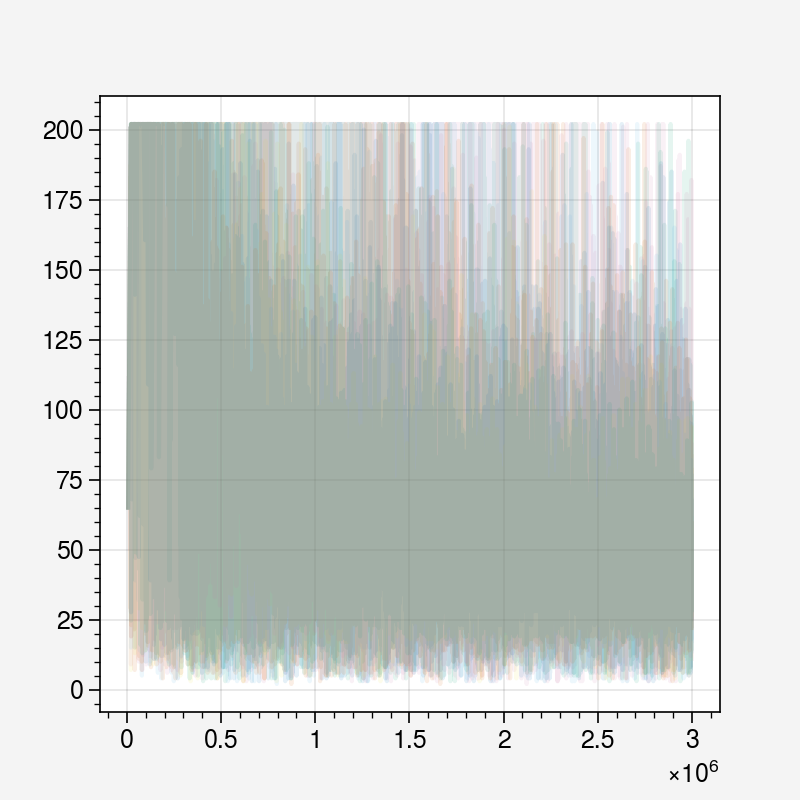

In [59]:
plt.plot(xs, ys_indiv.T, alpha=0.1)

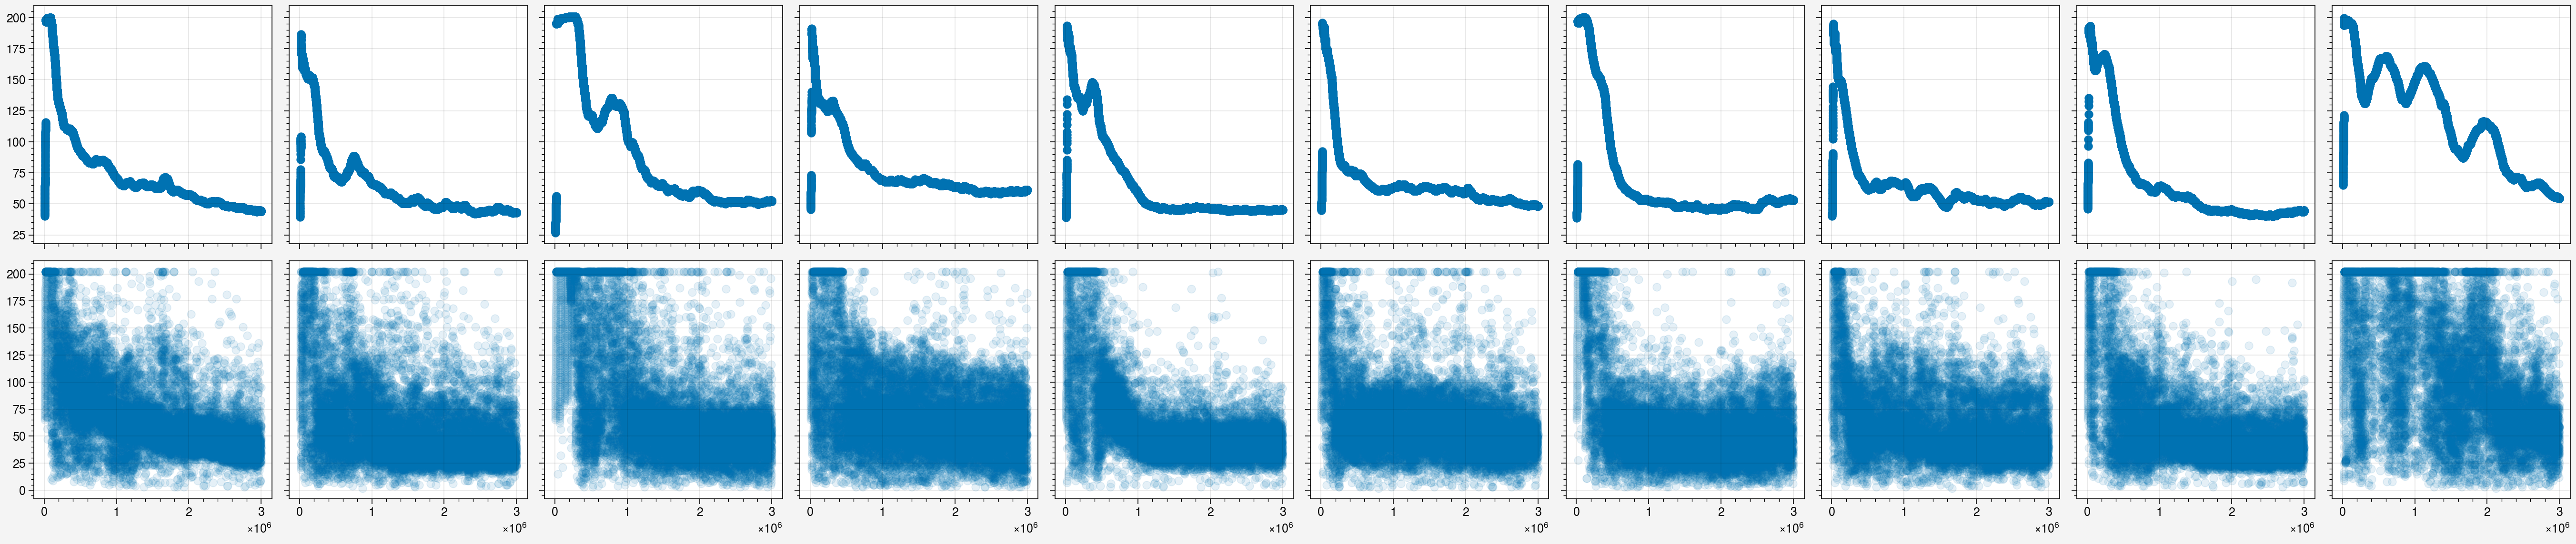

In [61]:
fig, ax = pplt.subplots(nrows=2, ncols=10)
for i in range(10):
    ax[0, i].scatter(xs, ys[i])
    ax[1, i].scatter(xs, ys_indiv[i], alpha=0.1)

In [64]:
exp_name

'nav_pdistal_auxcat/nav_pdistal_batch16auxcatfacewall'

In [99]:
df = load_exp_df(exp_name, trial_num=0)

subdf = df[df['metric'] == 'charts/episodic_length']
x = np.array(subdf['step'])
y = np.array(subdf['value'])
idx = np.argwhere(x >= timestep)[0][0]
y[idx-20:idx+20].mean()

77.275

In [ ]:
y[idx

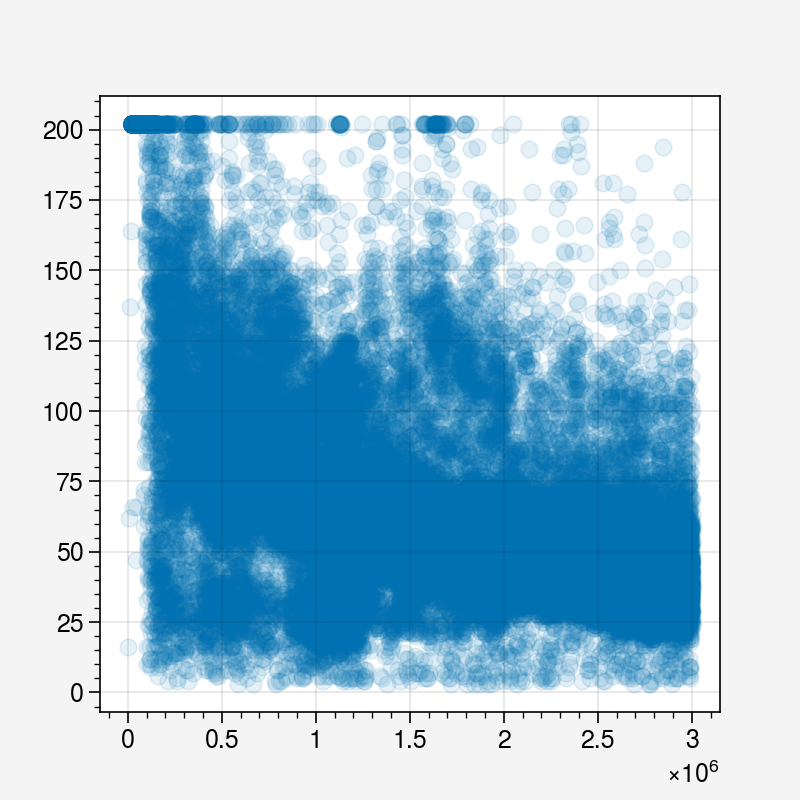

In [84]:
plt.scatter(x, y, alpha=0.1)

In [76]:
subdf

Unnamed: 0                  metric  value       step
47280           0  charts/episodic_length   16.0     1600.0
47281           1  charts/episodic_length   62.0     6200.0
47282           2  charts/episodic_length  137.0    13700.0
47283           3  charts/episodic_length  164.0    16400.0
47284           4  charts/episodic_length  202.0    20200.0
...           ...                     ...    ...        ...
94555       47275  charts/episodic_length   39.0  2999800.0
94556       47276  charts/episodic_length   24.0  2999900.0
94557       47277  charts/episodic_length   47.0  2999900.0
94558       47278  charts/episodic_length   41.0  2999900.0
94559       47279  charts/episodic_length   49.0  3000000.0

[47280 rows x 4 columns]

In [62]:
xs

array([   6500.,    6700.,    6900., ..., 2999300., 2999500., 2999700.])

In [43]:
res = evalu(model, obs_rms, env_kwargs=env_kwargs, new_aux=True, 
            auxiliary_truth_sizes=[1], n=25, seed=3, data_callback=nav_data_callback)


In [53]:
for res in all_res:
    print(np.vstack(res['data']['pos'])[res['ep_ends'], :])

[[212.72627015 207.73681678]
 [289.07214079   5.81923452]
 [130.95912746 231.57981316]
 [255.99402479 291.15299774]
 [178.42151163   6.62394052]
 [ 16.89473692 283.34266657]
 [281.10137358 233.60134789]
 [ 54.56430308  25.88498741]
 [ 53.04787765 218.14700891]
 [158.14937644 277.77090251]
 [ 35.5924678   50.2012349 ]
 [157.12599138 190.18219128]
 [193.74309183 119.89480085]
 [113.66812443 150.73965332]
 [ 78.07445741 165.98433198]
 [265.48634049 109.95324782]
 [ 59.90234942 149.35588147]
 [272.16784743 130.09204483]
 [125.69868097 268.16293591]
 [100.7029549  171.06452092]
 [255.41617903 177.94093018]
 [178.40184934  75.67248291]
 [265.23817736 154.30231951]
 [ 22.99980122 161.70182106]
 [183.45235113 110.18590134]]
[[212.72627015 207.73681678]
 [289.07214079   5.81923452]
 [130.95912746 231.57981316]
 [255.99402479 291.15299774]
 [178.42151163   6.62394052]
 [ 16.89473692 283.34266657]
 [281.10137358 233.60134789]
 [ 54.56430308  25.88498741]
 [ 53.04787765 218.14700891]
 [158.1493764

In [44]:
res['ep_ends']

array([  17,  163,  365,  416,  618,  722,  924,  947, 1042, 1111, 1171,
       1260, 1341, 1451, 1528, 1606, 1723, 1787, 1799, 1861, 1929, 1953,
       2059, 2183, 2251], dtype=int64)

array([[212.72627015, 207.73681678],
       [289.07214079,   5.81923452],
       [130.95912746, 231.57981316],
       [255.99402479, 291.15299774],
       [178.42151163,   6.62394052],
       [ 16.89473692, 283.34266657],
       [281.10137358, 233.60134789],
       [ 54.56430308,  25.88498741],
       [ 53.04787765, 218.14700891],
       [158.14937644, 277.77090251],
       [ 35.5924678 ,  50.2012349 ],
       [157.12599138, 190.18219128],
       [193.74309183, 119.89480085],
       [113.66812443, 150.73965332],
       [ 78.07445741, 165.98433198],
       [265.48634049, 109.95324782],
       [ 59.90234942, 149.35588147],
       [272.16784743, 130.09204483],
       [125.69868097, 268.16293591],
       [100.7029549 , 171.06452092],
       [255.41617903, 177.94093018],
       [178.40184934,  75.67248291],
       [265.23817736, 154.30231951],
       [ 22.99980122, 161.70182106],
       [183.45235113, 110.18590134]])

In [6]:
aux_tasks = ['none', 'catfacewall', 'catquad', 'catwall01', 'catwall0', 'catwall1']
aux_labels = ['Control', 'Faced Wall', 'Position Quadrant', 'Categ. East/North Wall', 'Categ. East Wall', 'Categ. North Wall']

# aux = 'catfacewall'
aux = 'none'
batch = 16
chk = 300
timestep = 16 * 100 * chk
num_trials = 3

if aux == 'none':
    exp_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch}aux{aux}'
else:
    # exp_name = f'nav_pdistal_auxcat/nav_pdistal_batch{batch}aux{aux}coef1'
    exp_name = f'nav_pdistal_auxcat/nav_pdistal_batch{batch}aux{aux}'

xs, ys, start_x, start_y = average_runs(exp_name, 'length', ignore_first=100, ewm=0.001,
                   ret=True)
idx = np.argwhere(xs >= timestep)[0][0]
y = ys[:num_trials, idx]

model, obs_rms, env_kwargs = load_model_and_env(exp_name, 0)

for trial in range(num_trials):
    exp_name_t = f'{exp_name}_t{trial}'
    chk_path = Path('../trained_models/checkpoint/')/exp_name_t


In [7]:
model, obs_rms = torch.load(chk_path/f'{chk}.pt')

res = evalu(model, obs_rms, env_kwargs=env_kwargs, new_aux=False, 
            auxiliary_truth_sizes=[1], n=10, )

# Collect trajectories to see unique behaviors

In [156]:
aux_tasks = ['none', 'catfacewall', 'catquad', 'catwall01', 'catwall0', 'catwall1']
aux_labels = ['Control', 'Faced Wall', 'Position Quadrant', 'Categ. East/North Wall', 'Categ. East Wall', 'Categ. North Wall']
batch_sizes = [16, 32]
all_chks = {16: [0, 50, 100, 150, 300, 600, 1000, 1500],
            32: [0, 20, 40, 80, 150, 300, 600, 900]}
trials = range(10)
keep_keys = ['actions',  'data',  'dones']

# all_res = {}
# for i, batch in enumerate(batch_sizes):
#     all_res[batch] = {}
#     for aux in aux_tasks:
#         all_res[batch][aux] = {}
#         for trial in trials:
#             all_res[batch][aux][trial] = {}

for batch in batch_sizes:
    chks = all_chks[batch]
    for aux in aux_tasks:
        for trial in tqdm(trials):
            new_aux = True
            if aux == 'none':
                exp_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch}aux{aux}'
                new_aux = False
            else:
                exp_name = f'nav_pdistal_auxcat/nav_pdistal_batch{batch}aux{aux}coef1'
                
            exp_name_t = f'{exp_name}_t{trial}'
            env_kwargs = pickle.load(open(f'../trained_models/ppo/{exp_name}_env', 'rb'))
            chk_path = Path('../trained_models/checkpoint/')/exp_name_t
            
            for chk in chks:
                if chk in all_res[batch][aux][trial]:
                    continue
                model, obs_rms = torch.load(chk_path/f'{chk}.pt')
                res = evalu(model, obs_rms, env_kwargs=env_kwargs, new_aux=new_aux, 
                    auxiliary_truth_sizes=[1], n=100, data_callback=nav_data_callback)
                
                for key in list(res.keys()):
                    if key not in keep_keys:
                        del res[key]
                        
                all_res[batch][aux][trial][chk] = res

                
# aux = 'catfacewall'
# aux = 'none'
# batch = 16
# chk = 300
# timestep = 16 * 100 * chk
# num_trials = 3

# if aux == 'none':
#     exp_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch}aux{aux}'
# else:
#     exp_name = f'nav_pdistal_auxcat/nav_pdistal_batch{batch}aux{aux}coef1'
#     # exp_name = f'nav_pdistal_auxcat/nav_pdistal_batch{batch}aux{aux}'

# model, obs_rms, env_kwargs = load_model_and_env(exp_name, 0)

# for trial in range(num_trials):
#     exp_name_t = f'{exp_name}_t{trial}'
#     chk_path = Path('../trained_models/checkpoint/')/exp_name_t

    
# model, obs_rms = torch.load(chk_path/f'{chk}.pt')

# res = evalu(model, obs_rms, env_kwargs=env_kwargs, new_aux=False, 
#             auxiliary_truth_sizes=[1], n=100, data_callback=nav_data_callback)

 10%|█████▌                                                  | 1/10 [04:59<44:57, 299.76s/it]


KeyboardInterrupt: 

In [235]:
condensed = {}
for batch in batch_sizes:
    condensed[batch] = {}
    for aux in aux_tasks:
        condensed[batch][aux] = {}
        for trial in trials:
            condensed[batch][aux][trial] = {}


for batch in all_res:
    for aux in all_res[batch]:
        for trial in all_res[batch][aux]:
            for chk in all_res[batch][aux][trial]:
                condensed[batch][aux][trial][chk] = {}
                condensed[batch][aux][trial][chk]['actions'] = torch.vstack(all_res[batch][aux][trial][chk]['actions'])
                condensed[batch][aux][trial][chk]['dones'] = np.vstack(all_res[batch][aux][trial][chk]['dones'])
                condensed[batch][aux][trial][chk]['data'] = {}
                condensed[batch][aux][trial][chk]['data']['pos'] = np.vstack(all_res[batch][aux][trial][chk]['data']['pos'])
                condensed[batch][aux][trial][chk]['data']['angle'] = np.vstack(all_res[batch][aux][trial][chk]['data']['angle'])
                
                

In [236]:
pickle.dump(condensed, open('data/trajectories/auxcatcoef1_condensed2', 'wb'))

In [237]:
batch = 16
aux = 'none'
trial = 1
chk = 1000

res = all_res[batch][aux][trial][chk]
ep_pos = split_by_ep(res['data']['pos'], res['dones'])
ep_angles = split_by_ep(res['data']['angle'], res['dones'])

In [242]:
angles

34

[array([131.31051143,  11.57045969])]

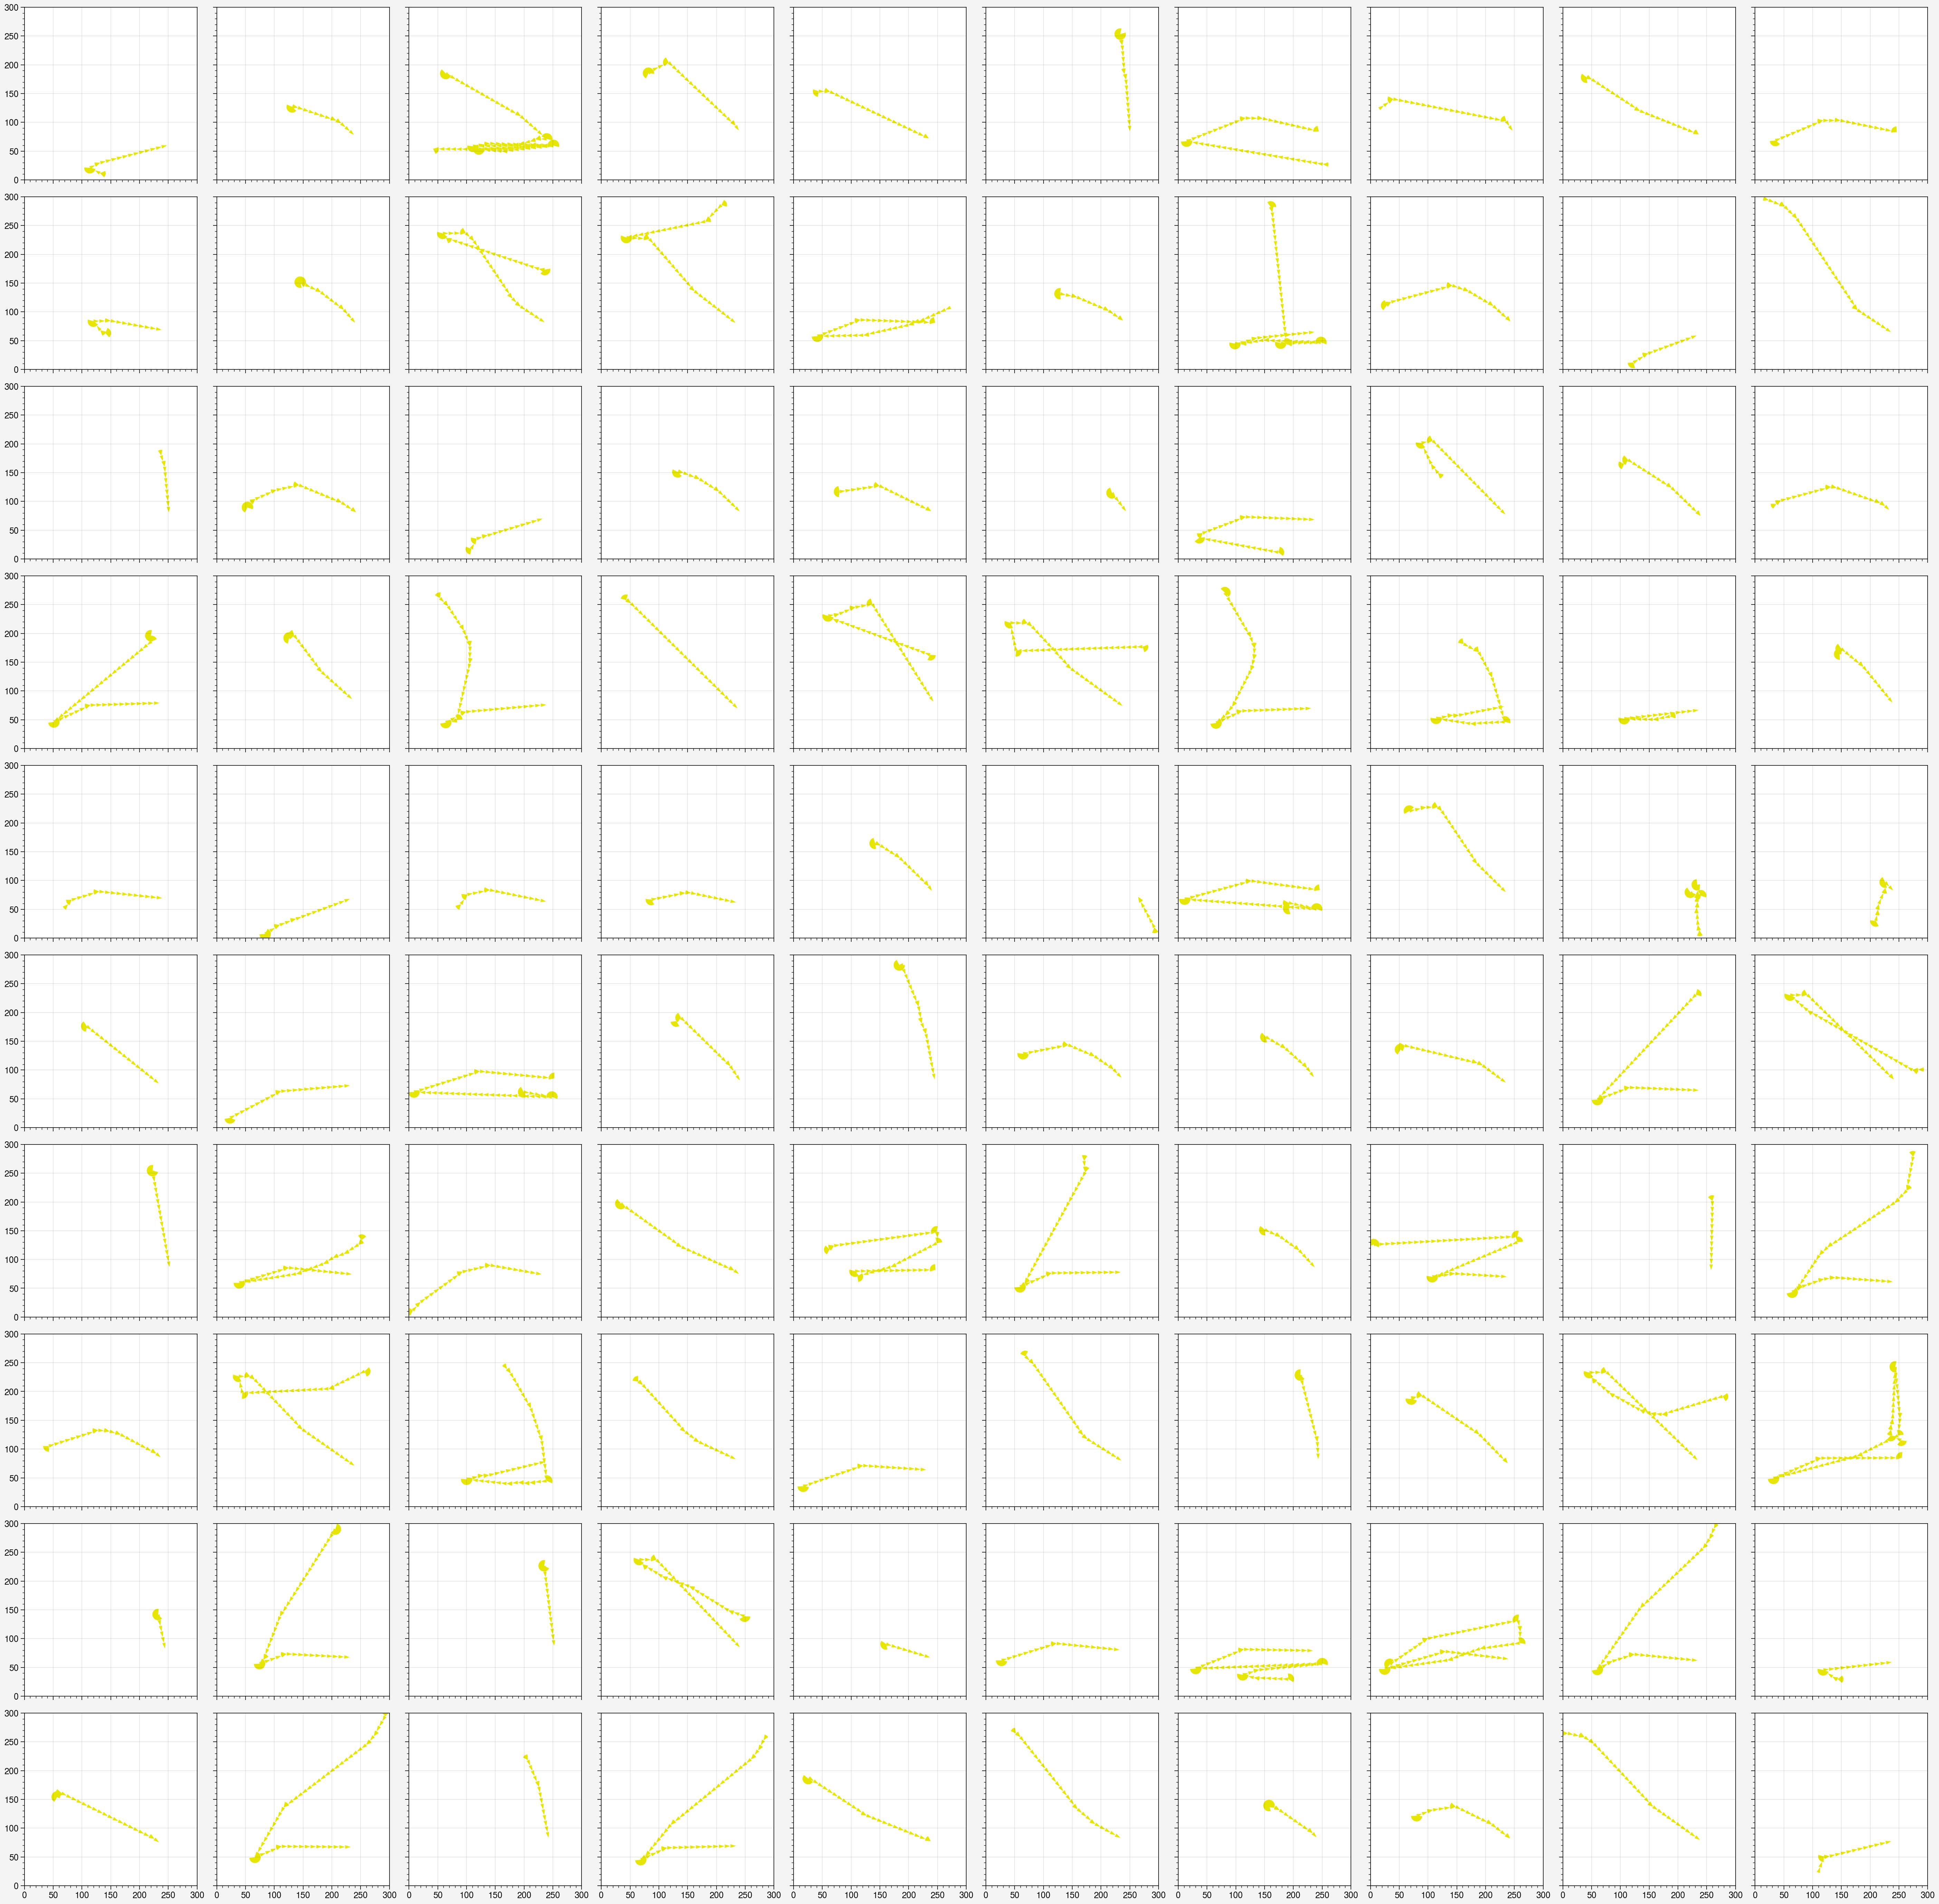

In [245]:
fig, ax = pplt.subplots(nrows=10, ncols=10)
for i, (pos, angles) in enumerate(zip(ep_pos, ep_angles)):
    for p, a in zip(pos, angles):
        draw_character(p[0], a[0], ax=ax[i])
ax.format(xlim=[0, 300], ylim=[0, 300])